# Modeling of National US Education



In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

In [2]:
x_train = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_train.csv", index_col=0)
y_train = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_train.csv", index_col=0)

x_test = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_test.csv", index_col=0)
y_test = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_test.csv", index_col=0)

In [3]:
print(x_train.shape)
print(y_train.shape)
y_train_1d = y_train.values.flatten()
y_train_1d.shape

(12, 10)
(12, 1)


(12,)

# I. Linear Regression

In [4]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [5]:
pipe.fit(x_train, y_train_1d)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001BC660C3160>)),
                ('linearregression', LinearRegression())])

In [6]:
y_tr_pred = pipe.predict(x_train)
y_te_pred = pipe.predict(x_test)

In [7]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.9832351548002036, -151.82556685189755)

In [8]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.2509510933467993, 4.092567442237282)

In [9]:
k = [k+1 for k in range(len(x_train.columns))]
grid_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

lr_grid_cv.fit(x_train, y_train)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

lr_grid_cv.best_params_

C:\Users\book_\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'selectkbest__k': 5}

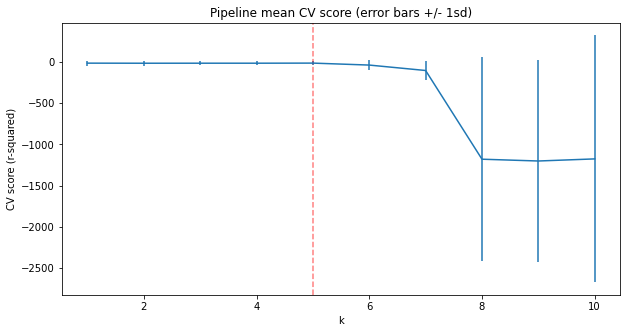

In [10]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [11]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = x_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

ValueError: Length of passed values is 1, index implies 5.

In [12]:
print(selected)
print(x_train.columns)
print(coefs)
print(features)

[False  True False False  True False  True  True  True False]
Index(['ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE'],
      dtype='object')
[[ 1.97440192 -0.33446473  4.88019353 -4.48278908  0.45761949]]
Index(['TOTAL_REVENUE', 'LOCAL_REVENUE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE'],
      dtype='object')


The out put for the "Series" Line of code should have come out as:

INSTRUCTION_EXPENDITURE: 4.88019353

TOTAL_REVENUE: 1.97440192

OTHER_EXPENDITURE: 0.45761949

LOCAL_REVENUE: -0.33446473

SUPPORT_SERVICES_EXPENDITURE: -4.48278908

This is interesting as it shows a strong positive corrilation with Instructional expenditures, which is to be expected. However the strong negative corrialtion with Support Services is not. Support services in schools are things such as:

School Nurse
Guidance Counselor
English Learners
Behavior Specialist
Instructional Specialist
Speech Specialist
Remedial Services
ect.

The implication here is that these hurt the overall scores. So what we are going to do is look at this same model but by state instead of using just the national data.

In [13]:
x_train_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_train_states.csv", index_col=0)
y_train_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_train_states.csv", index_col=0)

x_test_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/x_test_states.csv", index_col=0)
y_test_s = pd.read_csv("C:/Users/book_/OneDrive/Desktop/Data_Storage/US_Education/clean_data/y_test_states.csv", index_col=0)

In [14]:
y_train_s1d = y_train_s.values.flatten()
y_train_s1d.shape

(612,)

In [18]:
pipe_s = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

pipe_s.fit(x_train_s, y_train_s1d)

k_s = [k+1 for k in range(len(x_train_s.columns))]
grid_params_s = {'selectkbest__k': k_s}

lr_grid_cv_s = GridSearchCV(pipe_s, param_grid=grid_params_s, cv=5, n_jobs=-1)

lr_grid_cv_s.fit(x_train_s, y_train_s1d)

score_mean_s = lr_grid_cv_s.cv_results_['mean_test_score']
score_std_s = lr_grid_cv_s.cv_results_['std_test_score']
cv_k_s = [k for k_s in lr_grid_cv_s.cv_results_['param_selectkbest__k']]

lr_grid_cv_s.best_params_

{'selectkbest__k': 2}

ValueError: shape mismatch: objects cannot be broadcast to a single shape

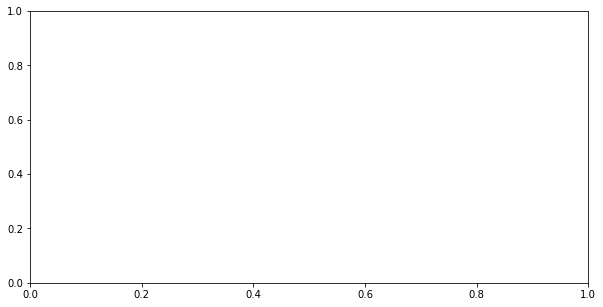

In [19]:
best_k_s = lr_grid_cv_s.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k_s, score_mean_s, yerr=score_std_s)
plt.axvline(x=best_k_s, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [20]:
selected = lr_grid_cv_s.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv_s.best_estimator_.named_steps.linearregression.coef_
features = x_train_s.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

LOCAL_REVENUE      4.543618
FEDERAL_REVENUE   -4.427660
dtype: float64

This turned out less informative than the national data.

# II. Random Forest Model

In [21]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

rf_default_cv_results = cross_validate(RF_pipe, x_train, y_train_1d, cv=5)

In [22]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-68.05477041,  -1.50903477,  -4.36430453, -21.58762144,
        -0.09309848])

In [23]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-19.121765925789468, 25.65385164620848)

In [24]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [25]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(x_train, y_train)

C:\Users\book_\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [26]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 20, 'standardscaler': StandardScaler()}

In [27]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, x_train, y_train_1d, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-45.17091681,  -0.61993267,  -5.0765157 , -20.91264   ,
        -0.64994329])

In [28]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-14.485989693559043, 17.059358160740814)

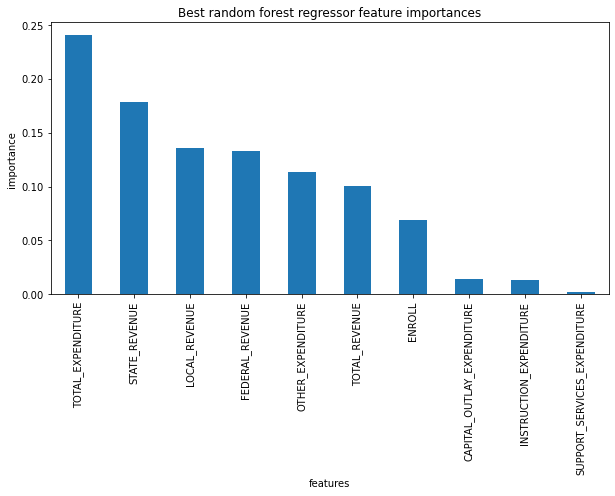

In [29]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=x_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

# Model Comparison

In [31]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, x_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(0.7939897235677071, 0.39289840624031586)

In [33]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(x_test))

5.000485644366677

In [34]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, x_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(1.0278594771242222, 1.0181168528065416)

In [36]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(x_test))

1.1651960784313928

We have a significantly lower score on the Random Forest model